# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

torch.manual_seed(1)

In [2]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x7F1FC401F250>, 5)


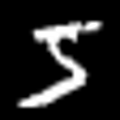

In [3]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [5]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [6]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [7]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################
mu = torch.mean(ims_train, dim=(0, 1, 2))
std = torch.mean(ims_train, dim=(0, 1, 2))

We normalize the data as below.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [9]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-1.), tensor(6.6534))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [10]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################
dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
dl_test = DataLoader(
    ds_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [11]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [19]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        layers.append(nn.Linear(nInput, nHidden))
        layers.append(act_fn)
        for i in range(1, nLayer):
            layers.append(nn.Linear(nHidden, nHidden))
            layers.append(act_fn)
        layers.append(nn.Linear(nHidden, nOutput))
        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.model(x)
        return x

In [20]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [21]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [22]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [23]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        output = model.forward(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [24]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [25]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352449
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.707289
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.532663
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.519744
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.425182
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.328896
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.215765
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.318127
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.214472
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.277549

Train set: Average loss: 0.2546, Accuracy: 52309/60000 (87.2%)


Test set: Average loss: 0.2964, Accuracy: 9149/10000 (91.490%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.250154
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.189128
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.151998
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.133746
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.207578
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.187199
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.229091
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [26]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 10 #5
nHidden = 50 #30
act_fn = nn.LogSigmoid()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10 #18
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332053
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.634820
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.277991
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.792353
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.786180
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.516561
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.408078
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.288483
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.613154
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.239228

Train set: Average loss: 0.0658, Accuracy: 43071/60000 (71.8%)


Test set: Average loss: 0.2570, Accuracy: 9261/10000 (92.610%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078160
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.330871
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.170190
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.289358
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.124584
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.419562
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.096378
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [27]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimension after the convolutional blocks. 
# A linear layers expect input of the size (B, H) with batch size B and feature size H
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 0), nn.ReLU(), \
                                   nn.Conv2d(32, 64, 3, 1, 0), nn.ReLU(), \
                                   nn.MaxPool2d(2, 2, 0), nn.Dropout(0.25), \
                                   nn.Flatten(), nn.Linear(9216, 128), nn.ReLU(), \
                                   nn.Dropout(0.5), nn.Linear(128,10))
    def forward(self, x):
        #x = torch.flatten(x, 1)
        return self.model(x)

In [28]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [29]:
optimizer = optim.Adam(cnn.parameters())

In [30]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286173
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.312677
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.187301
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.075680
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.048019
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.078526
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.109659
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.269044
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.171462
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.062868

Train set: Average loss: 0.0438, Accuracy: 56499/60000 (94.2%)


Test set: Average loss: 0.0561, Accuracy: 9817/10000 (98.170%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.060785
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.084369
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.027246
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033571
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.023703
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.041527
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.057290
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: 10% 


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [31]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [32]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [33]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [34]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = torch.mean(ims_train, dim=(0,1,2))
std = torch.std(ims_train, dim=(0,1,2))


In [35]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [36]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################
transform_train = transforms.Compose([
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu, std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std),
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [37]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [38]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [39]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 0), nn.ReLU(), \
                                   nn.Conv2d(32, 64, 3, 1, 0), nn.ReLU(), \
                                   nn.MaxPool2d(2, 2, 0), nn.Dropout(0.25), \
                                   nn.Flatten(), nn.Linear(12544, 128), nn.ReLU(), \
                                   nn.Dropout(0.5), nn.Linear(128,10))
    def forward(self, x):
        #x = torch.flatten(x, 1)
        return self.model(x)

Let's try again

In [40]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.310475
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.274994
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.104172
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.001589

Train set: Average loss: 1.9547, Accuracy: 9962/50000 (19.9%)


Test set: Average loss: 1.8738, Accuracy: 2830/10000 (28.300%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.111769
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.977497
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.903890
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.936964

Train set: Average loss: 1.9311, Accuracy: 13432/50000 (26.9%)


Test set: Average loss: 1.7793, Accuracy: 3299/10000 (32.990%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.859786
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.918123
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.944368
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.715811

Train set: Average loss: 1.9303, Accuracy: 14543/50000 (29.1%)


Test set: Average loss: 1.8299, Accuracy: 3220/10000 (32.200%)

Train Epoch: 4 [0/50000 (0

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. 

It as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
print(cnn)

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [ ]:
#########################################################################
# TODO: Adapt the Resnet to work on CIFAR
#########################################################################


In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %